## Alter the following parameters to provide different graphs below
#### Ensure that the relevant csv files have been added

In [9]:
file_dir = "../test_1_8_11_2021/"
file_name_list = [file_dir + "svtD01.csv", file_dir + "svtD02.csv"]
drifter_names = ['D01', 'D02']
frequency = 30
start_time = "1:56:00" # +8 -> 9:56 AM
end_time = "2:48:00" # +8 -> 10:48 AM

In [10]:
import os, csv
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
def read_from_CSV(file_name, frequency, start_time, end_time):
  data = []
  with open(file_name, 'r', newline='') as csvfile:
    csv_reader = csv.reader(csvfile,quoting=csv.QUOTE_ALL)
    for idx, row in enumerate(csv_reader):
      if '#FILE ERASED AT' not in row:
        if idx != 0:
          if(idx % frequency == 0):
            if(row[1] > start_time and row[1] < end_time):
              data.append(row)
    csvfile.close()
    return data

In [12]:
dfs = [None] * 2
for idx, file_name in enumerate(file_name_list):
  data = read_from_CSV(file_name, frequency, start_time, end_time)
  dfs[idx] = pd.DataFrame(data, columns=['Date', 'Time', 'Longitude', 'Latitude', 'GPS Age'])

for df in dfs:
  print(df.head())
  
drifter_list = dfs

        Date     Time    Longitude      Latitude GPS Age
0  8/11/2021  1:56:28  115.8286332  -31.99753783     384
1  8/11/2021  1:56:57   115.828553  -31.99754633     316
2  8/11/2021  1:57:27  115.8285553  -31.99756633     350
3  8/11/2021  1:57:57  115.8285507    -31.997598     249
4  8/11/2021  1:58:27  115.8285563  -31.99761367     291
        Date     Time    Longitude      Latitude GPS Age
0  8/11/2021  1:56:22  115.8286573  -31.99754883     135
1  8/11/2021  1:56:52  115.8286378  -31.99756467      55
2  8/11/2021  1:57:22  115.8286248   -31.9975955     101
3  8/11/2021  1:57:52  115.8286188    -31.997628      21
4  8/11/2021  1:58:22  115.8286085  -31.99764567      82


In [13]:
import math
from datetime import datetime

# same as TinyGPS lib calc
def getDistance(lat1, lon1, lat2, lon2):
    delta = math.radians(lon1-lon2)
    sdlong = math.sin(delta)
    cdlong = math.cos(delta)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    slat1 = math.sin(lat1)
    clat1 = math.cos(lat1)
    slat2 = math.sin(lat2)
    clat2 = math.cos(lat2)
    delta = (clat1 * slat2) - (slat1 * clat2 * cdlong)
    delta = delta ** 2
    delta += (clat2 * sdlong) ** 2
    delta = math.sqrt(delta)
    denom = (slat1 * slat2) + (clat1 * clat2 * cdlong)
    delta = math.atan2(delta, denom)
    return delta * 6372795

In [14]:
def split_time_from_df(drifter):
  drifter_stamps = []
  for ii in range(len(drifter) - 1):
    date_stamp = df.Date[ii]
    new_date_stamp = date_stamp.split('/')

    timestamp = df.Time[ii]
    new_timestamp = timestamp.split(':')
    drifter_stamps.append([*new_date_stamp, *new_timestamp])
  return drifter_stamps

In [15]:
def calc_overall_local_currents(drifter_list, drifter_names):
    start_time = datetime(2021, 11, 8, 1, 56, 0)           # "1:56:00" +8 -> 9:56 AM
    end_time = datetime(2021, 11, 8, 2, 48, 0)             # "2:48:00" +8 -> 10:48 AM
    time_delta_s = (end_time - start_time).total_seconds()
    print('Total drift time')
    print(time_delta_s, 's\n')
    for idx, drifter in enumerate(drifter_list):
      lat_1 = float(drifter.Latitude[0])
      lon_1 = float(drifter.Longitude[0])
      lat_2 = float(drifter.Latitude[len(drifter) - 1])
      lon_2 = float(drifter.Longitude[len(drifter) - 1])
    
      print(drifter_names[idx])
      dist = getDistance(lat_1, lon_1, lat_2, lon_2)
      print("Total distance: ", dist, 'm')
      velocity = dist/time_delta_s
      print("Velocity: ", velocity, 'm/s')

calc_overall_local_currents(drifter_list, drifter_names)

Total drift time
3120.0 s

D01
Total distance:  255.19781971406795 m
Velocity:  0.08179417298527819 m/s
D02
Total distance:  317.4120931238725 m
Velocity:  0.10173464523201042 m/s


In [16]:
def calc_individual_local_currents(drifter_list, drifter_names):
    for idx, drifter in enumerate(drifter_list):
      velocity_list = []
      drifter_stamps = split_time_from_df(drifter)
      for ii in range(len(drifter_stamps) - 1):
        stamp = drifter_stamps[ii]
        stamp = list(map(int, stamp))
        stamp_2 = drifter_stamps[ii + 1]
        stamp_2 = list(map(int, stamp_2))
        start_time = datetime(stamp[2], stamp[1], stamp[0], stamp[3], stamp[4], stamp[5])
        end_time = datetime(stamp_2[2], stamp_2[1], stamp_2[0], stamp_2[3], stamp_2[4], stamp_2[5])
        time_delta_s = (end_time - start_time).total_seconds()
        lat_1 = float(drifter.Latitude[ii])
        lon_1 = float(drifter.Longitude[ii])
        lat_2 = float(drifter.Latitude[ii + 1])
        lon_2 = float(drifter.Longitude[ii + 1])
      
        dist = getDistance(lat_1, lon_1, lat_2, lon_2)
        # print('Distance:', dist, 'm')
        velocity = dist/time_delta_s
        velocity_list.append(velocity)
      yield velocity_list
  
currents_velocities = calc_individual_local_currents(drifter_list, drifter_names)

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


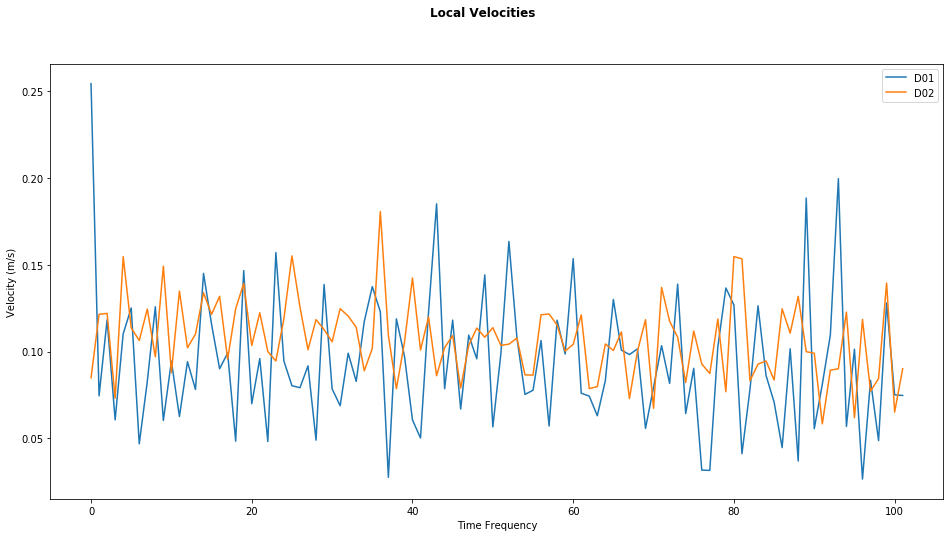

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_local_velocities(currents_velocities, drifter_names):
  fig = plt.figure(figsize=(16,8))
  
  fig.suptitle("""Local Velocities\n\n""", fontweight ="bold") 
  for idx, curr in enumerate(currents_velocities):
    plt.plot(curr, label=drifter_names[idx])
    plt.ylabel('Velocity (m/s)')
    plt.xlabel('Time Frequency')
    plt.legend()
  fig.show()

plot_local_velocities(currents_velocities, drifter_names)